In [142]:
import pandas as pd
import geopandas as gpd
import csv
import requests
import zipfile
import os
import io
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.plot
%matplotlib inline

In [105]:
from processing.retriving_data import RetrieveBoundaries

In [100]:
!ls

0_1_Data_exploration.ipynb  2_water_use.ipynb		 README.md
0_data_geocoding.ipynb	    3_deforestation_risk.ipynb
1_carbon_emissions.ipynb    4_biodiversity_impact.ipynb


In [5]:
processed_data = gpd.read_file('../Processed_data/located_lg_data.shp')
processed_data.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,Rubber,None,2400,China,None,NaN,NaN,Unknown,Low,POINT (104.99993 35.00007)
1,Rubber,None,1300,Malaysia,None,NaN,NaN,Unknown,Low,POINT (102.26568 4.56938)
2,Rubber,None,1000,United States,None,NaN,NaN,Unknown,Low,POINT (-100.44588 39.78373)
3,Rubber,None,730,Japan,None,NaN,NaN,Unknown,Low,POINT (139.23942 36.57484)
4,Rubber,None,490,India,None,NaN,NaN,Unknown,Low,POINT (78.66774 22.35111)


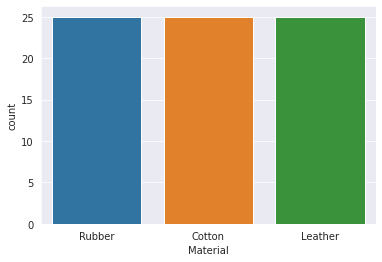

In [10]:

sns.set_style(style="darkgrid")
ax = sns.countplot(x="Material", data=processed_data)

In [11]:
processed_data.groupby('Material')['Volume'].sum()

Material
Cotton     53457
Leather    12048
Rubber     25196
Name: Volume, dtype: int64

## Crop production - case study

As a starting point we need crop especific data as can be yield or harvest area to compute the different metrics for each commodity. Currently exist detailed information at country level but this information is not homogenised for a global scale. However, there are some global scale crop-specifc dataset (e.g. Earthstat or Mapspam) but the spatial resolution and temporal resolution could be improvde, for example using machine learning techniques. 

the currentcrop specific data that we have for a global scale includes:

- country data from FAOSTAT regarding harvest area, yield and production in a year basis
- Earthstat 2000 gloabl harvest, production and year dataset for different commodities.

We can use the crop data from earthstat as initial dataset and extrapolate the inforation up to 2019 using the data from FAOSTAT.


### 1. Get crop specific information at country level from FAOSTAT

This data is country specific and has year information up to 2019.

In [38]:
## download FAOSTAT data forcotton in a year basis since 2000 up to 2019.
## http://www.fao.org/faostat/en/#data/QC

url = "http://fenixservices.fao.org/faostat/api/v1/en/data/QC?area=5000%3E&area_cs=FAO&element=2312&item=328&item_cs=FAO&year=2000%2C2001&show_codes=true&show_unit=true&show_flags=true&null_values=false&output_type=csv"

with requests.Session() as s:
    download = s.get(url)

    decoded_content = download.content.decode('utf-8')

    data = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(data)
FAO_df = pd.DataFrame(my_list, columns=my_list[0])

In [39]:
FAO_df = FAO_df.drop(index=0)
FAO_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
1,QC,Crops,2,Afghanistan,5312,Area harvested,328,Seed cotton,2000,2000,ha,50000,*,Unofficial figure
2,QC,Crops,2,Afghanistan,5312,Area harvested,328,Seed cotton,2001,2001,ha,50000,*,Unofficial figure
3,QC,Crops,3,Albania,5312,Area harvested,328,Seed cotton,2000,2000,ha,990,F,FAO estimate
4,QC,Crops,3,Albania,5312,Area harvested,328,Seed cotton,2001,2001,ha,840,F,FAO estimate
5,QC,Crops,4,Algeria,5312,Area harvested,328,Seed cotton,2000,2000,ha,141,Im,FAO data based on imputation methodology


In [82]:
# get fao data for indonesia
url = "http://fenixservices.fao.org/faostat/api/v1/en/data/QC?area=101&area_cs=FAO&element=2312&item=328&item_cs=FAO&year=2000%2C2001%2C2002%2C2003%2C2004%2C2005%2C2006%2C2007%2C2008%2C2009%2C2010%2C2011%2C2012%2C2013%2C2014%2C2015%2C2016%2C2017%2C2018%2C2019&show_codes=true&show_unit=true&show_flags=true&null_values=false&output_type=csv"
with requests.Session() as s:
    download = s.get(url)

    decoded_content = download.content.decode('utf-8')

    data = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(data)
FAO_indonesia_df = pd.DataFrame(my_list, columns=my_list[0])

In [83]:
FAO_indonesia_df = FAO_indonesia_df.drop(index=0)
FAO_indonesia_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
1,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2000,2000,ha,11553,,Official data
2,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2001,2001,ha,10715,,Official data
3,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2002,2002,ha,9372,,Official data
4,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2003,2003,ha,6357,,Official data
5,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2004,2004,ha,7720,,Official data


### 2. Get 2000 cotton data from earthstat

- Harvested Area: hectares: Crop-specific data representing the average number of hectares harvested per land-area of a gridcell during the 1997-2003 era

In [56]:
# download data from earthstat
# http://www.earthstat.org/harvested-area-yield-175-crops/
url = "https://s3.us-east-2.amazonaws.com/earthstatdata/HarvestedAreaYield175Crops_Indvidual_Geotiff/cotton_HarvAreaYield_Geotiff.zip"

local_path = '../raw_data/cotton_earthstat'
if not os.path.isdir(local_path):
    os.mkdir(local_path)

    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    z.extractall(path=local_path) # extract to folder
    print("Data extracted!")

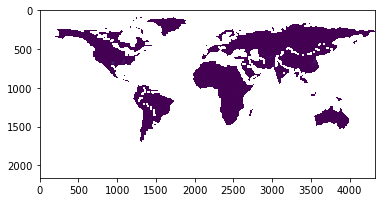

In [78]:
# Use rasterio to import the reprojected data as img
out_path = '../raw_data/cotton_earthstat/cotton_HarvAreaYield_Geotiff/cotton_HarvestedAreaHectares.tif'
with rio.open(out_path) as src:
    arr = src.read(out_shape=(src.height, src.width))



plt.imshow(arr[0])
plt.show()

In [84]:
# get country data from
url = "https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IDN_shp.zip"
local_path = '../raw_data/gadm_indonesia'
if not os.path.isdir(local_path):
    os.mkdir(local_path)

    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    z.extractall(path=local_path) # extract to folder
    print("Data extracted!")

Done
Data extracted!


In [91]:
gadm_ind = gpd.read_file('../raw_data/gadm_indonesia/gadm36_IDN_0.shp')
gadm_ind.head()

,fid,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,1.0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"MULTIPOLYGON (((122.87141 -10.96885, 122.87312..."


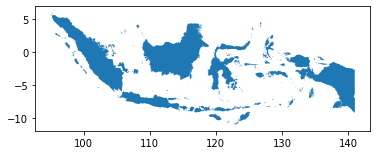

In [93]:
gadm_ind.plot()

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


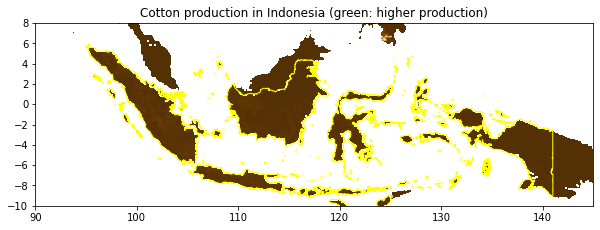

In [99]:
with rio.open('../raw_data/cotton_earthstat/cotton_HarvAreaYield_Geotiff/cotton_HarvestedAreaHectares.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[10,5])
    ax.set_ylim((-10,8))
    ax.set_xlim((90,145))
    rio.plot.show(dat, vmax=100, cmap='BrBG', ax=ax, transform=src.transform)
    gadm_ind.plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Cotton production in Indonesia (green: higher production)')

In [108]:
feature = RetrieveBoundaries(query='India')

Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'India')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=India


In [110]:

gdf = gpd.GeoDataFrame.from_features(feature.feature_json, crs='epsg:4326')
gdf

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"MULTIPOLYGON (((68.11138 23.60145, 68.11501 23...",India,35.523233,6.232527,97.395561,68.111379


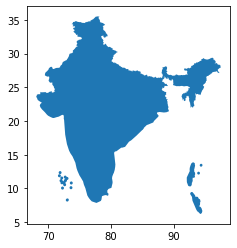

In [111]:
gdf.plot()

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


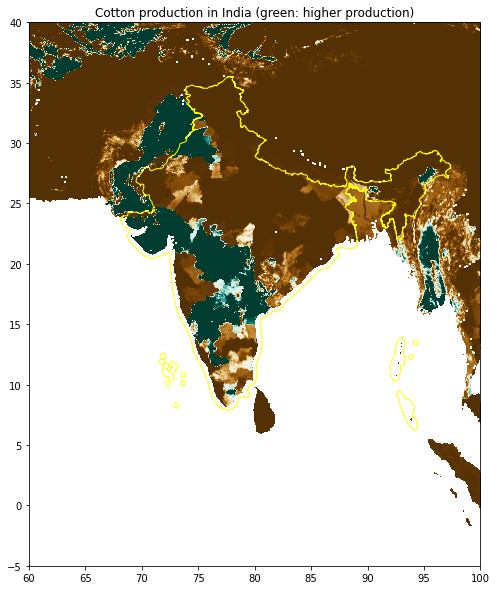

In [124]:
with rio.open('../raw_data/cotton_earthstat/cotton_HarvAreaYield_Geotiff/cotton_HarvestedAreaHectares.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((-5,40))
    ax.set_xlim((60,100))
    rio.plot.show(dat, vmax=100, cmap='BrBG', ax=ax, transform=src.transform)
    gdf.plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Cotton production in India (green: higher production)')

### 3. Upscale the cotton harvest area layer

Extrapolate up to 2019 the erthstat data by using an upscaling factor derived from the FAO data.


Upscaling_factor = harvest_area_start_year / harvest_area_end_year


#### 3.1  Calculation of the upscaling factor

In [122]:
## get upscaling factor for indonesia
upscaling_factor = float(FAO_indonesia_df.iloc[1].Value)/float(FAO_indonesia_df.iloc[0].Value)
print(f'The upscaling factor is: {upscaling_factor}')

The upscaling factor is: 0.9274647277763352


In [132]:
## ad upscaling factor to admin area
gadm_ind['scl_factor']=upscaling_factor
gadm_ind

,fid,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry,scl_factor
0,1.0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"MULTIPOLYGON (((122.87141 -10.96885, 122.87312...",0.927465


#### 3.2  Rasterize the admin area with the upscaling factor

In [130]:
#generate a raster mask with value 1 for the harvest area tiff
with rio.open('../raw_data/cotton_earthstat/cotton_HarvAreaYield_Geotiff/cotton_HarvestedAreaHectares.tif') as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'blockxsize': 432, 'blockysize': 224, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'}


In [135]:
!gdal_rasterize -l gadm36_IDN_0 -a scl_factor -ts 4320.0 2160.0 -a_nodata 1.0 -te -180.0 -90.0 180.0 90.0 -ot Float32 -of GTiff ../raw_data/gadm_indonesia/gadm36_IDN_0.shp ../raw_data/harvest_area_scale_factor_mask_v2.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [136]:
#check the mask
with rio.open('../raw_data/harvest_area_scale_factor_mask_v2.tif') as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 1.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0), 'tiled': False, 'interleave': 'band'}


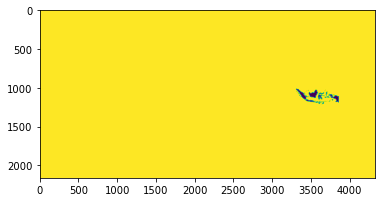

In [137]:
# Use rasterio to import the reprojected data as img
out_path = '../raw_data/harvest_area_scale_factor_mask_v2.tif'
with rio.open(out_path) as src:
    arr = src.read(out_shape=(src.height, src.width))



plt.imshow(arr[0])
plt.show()

#### 3.2  Generate the upscaling layer by multiplaying the two rasters

In [138]:
!gdal_calc.py -A ../raw_data/harvest_area_scale_factor_mask_v2.tif -B ../raw_data/cotton_earthstat/cotton_HarvAreaYield_Geotiff/cotton_HarvestedAreaHectares.tif --outfile=../Processed_data/cotton_2001_harvest_area.tif --calc="A*B"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

 77.. 77.. 77.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 87.. 87..

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


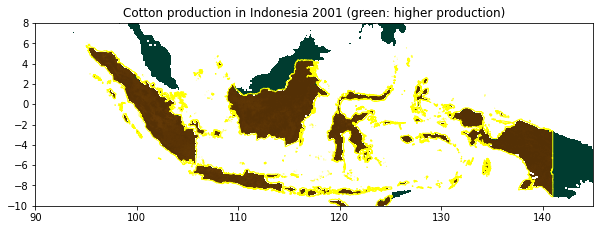

In [141]:


with rio.open('../Processed_data/cotton_2001_harvest_area.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[10,5])
    ax.set_ylim((-10,8))
    ax.set_xlim((90,145))
    rio.plot.show(dat, vmax=100, cmap='BrBG', ax=ax, transform=src.transform)
    gadm_ind.plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Cotton production in Indonesia 2001 (green: higher production)')

### 4. Post-processing: rescaling extrapolated data

Identifying discrepancies for example where the actual harvest area is greater than the area of the grid cell.